<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/Hierarchical_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You might need the data from here: http://www.stat.columbia.edu/~gelman/arm/examples/election88/

In [1]:
!pip install pyreadstat pyro-ppl 

In [2]:
import pyreadstat
import time 
import os
import torch
import requests
import sklearn.model_selection

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, Predictive

In [3]:
# Download input files
url = 'http://www.stat.columbia.edu/~gelman/arm/examples/election88/'

file1 = 'polls.dta'
r = requests.get(url+file1)
open(file1 , 'wb').write(r.content)

file2 = 'presvote.dta'
r = requests.get(url+file2)
open(file2 , 'wb').write(r.content)

848

In [4]:
# Data preprocessing

polls_df, meta = pyreadstat.read_dta('polls.dta')
polls_df = polls_df.dropna()
presvote_df, _ = pyreadstat.read_dta('presvote.dta')
presvote_df = presvote_df.rename(columns={'stnum2': 'state', 'g76_84pr':'previous_vote'})

# Apologies, for this, this is how they do it in the R code as well. 
# The list has length 51 since they add D.C as its own state.
state_to_region_mapping = torch.tensor([3,4,4,3,4,4,1,1,5,3,3,4,4,2,2,2,2,3,3,1,
                                        1,1,2,2,3,2,4,2,4,1,1,4,1,3,2,2,3,4,1,1,
                                        3,2,3,3,4,1,3,4,1,2,4])
state_to_region_mapping = state_to_region_mapping.repeat(len(polls_df), 1)
indices = torch.tensor(polls_df['state'].values, dtype=torch.int64) - 1
polls_df['region'] = state_to_region_mapping.gather(1, indices.view(-1, 1))
polls_df = polls_df.join(other=presvote_df.set_index('state'), on='state')

# Age
polls_df['age'] = polls_df['age'] - 1
age = torch.tensor(polls_df[["age"]].values, dtype=torch.int64)
n_age_categories = max(age) + 1

# Education
polls_df['edu'] = polls_df['edu'] - 1
edu = torch.tensor(polls_df[["edu"]].values, dtype=torch.int64)
n_edu_categories = max(edu) + 1

# State
polls_df['state'] = polls_df['state'] - 1
state = torch.tensor(polls_df[["state"]].values, dtype=torch.int64)
n_state_categories = max(state) + 1

# Region Full
polls_df['region_full'] = polls_df['region'] - 1
region_full = torch.tensor(polls_df[["region"]].values, dtype=torch.int64)
n_region_full_categories = max(region_full) + 1

# Age x Education
polls_df['age_edu'] = polls_df['age']*polls_df['edu']
age_edu = torch.tensor(polls_df[["age_edu"]].values, dtype=torch.int64)
n_age_edu_categories = max(age_edu) + 1

In [5]:
# Helper function to separate features and targets

def get_features_and_targets(dataframe):
  feature_names = ["female", "black", "previous_vote", "age", "edu", "age_edu", "region", "state"]
  features = []
  for feature in feature_names:
    if feature == "previous_vote":
      dtype = torch.float64
    else:
      dtype = torch.int64
    
    features.append(torch.tensor(dataframe[[feature]].values, dtype=dtype))
  targets = torch.tensor(dataframe[["bush"]].values,  dtype=torch.float64)
  return features, targets

In [6]:
# Split training and test data 

train_df, test_df = sklearn.model_selection.train_test_split(polls_df, train_size=10000)

train_features, train_targets = get_features_and_targets(train_df)
test_features, test_targets = get_features_and_targets(test_df)

In [7]:
# Helper function to calcualte logits for log. regression

def logit(beta, a, b, c, d, e, 
          female, black, v_prev_full, age, edu, age_edu, region_full, state):
    logits = beta[0] \
            +beta[1]*black \
            +beta[2]*female \
            +beta[4]*female*black \
            +beta[3]+v_prev_full \
            +a[age] \
            +b[edu] \
            +c[age_edu] \
            +d[state] \
            +e[region_full]
    return logits  

In [8]:
def model(female, black, v_prev_full, age, edu, age_edu, region_full, state, y=None):
      #Unifrom hyper-priors constraint between 0 and 100 for variances
      sigma_a = pyro.sample('sigma_a', dist.Uniform(0., 100.))
      sigma_b = pyro.sample('sigma_b', dist.Uniform(0., 100.))
      sigma_c = pyro.sample('sigma_c', dist.Uniform(0., 100.))
      sigma_d = pyro.sample('sigma_d', dist.Uniform(0., 100.))
      sigma_e = pyro.sample('sigma_e', dist.Uniform(0., 100.))
      
      #priors for hierarchical log reg
      beta = pyro.sample('beta', dist.Normal(0., 100.).expand([5]).to_event(1))
      a = pyro.sample("a", dist.Normal(0., sigma_a).expand(n_age_categories).to_event(1))
      b = pyro.sample("b", dist.Normal(0., sigma_b).expand(n_edu_categories).to_event(1))
      c = pyro.sample("c", dist.Normal(0., sigma_c).expand(n_age_edu_categories).to_event(1))
      d = pyro.sample("d", dist.Normal(0., sigma_d).expand(n_state_categories).to_event(1))
      e = pyro.sample("e", dist.Normal(0., sigma_e).expand(n_region_full_categories).to_event(1))

      logits = pyro.deterministic('logits', logit(beta, a, b, c, d, e, 
                                                  female, black, v_prev_full, age, edu, age_edu, region_full, state))

      with pyro.plate("data", len(female)):

        obs = pyro.sample("obs", dist.Bernoulli(logits = logits).to_event(1), obs=y)


In [12]:
# Train ADVI model
torch.manual_seed(0)

guide = AutoDiagonalNormal(model)
adaprop = pyro.optim.AdagradRMSProp(dict())
svi = SVI(model, guide, adaprop, loss=Trace_ELBO())

pyro.clear_param_store()
output_advi = pd.DataFrame(columns = ["t", "num_samples", "test_accuracy", "model"])

step_ids = []
average_log_predictives = []
train_time = 0

eval_steps = np.concatenate((np.arange(0, 200, 10),
                             np.arange(100, 1000, 100),
                             np.arange(1000, 5000, 1000)))

for j in range(5000):
    # calculate the loss and take a gradient step
    t0 = time.time()
    loss = svi.step(*train_features, train_targets)
    t1 = time.time()
    train_time += (t1-t0)

    if j in eval_steps:
      num_samples = 100
      predictive_svi = Predictive(model, guide=guide, num_samples=num_samples)
      test_predictions = predictive_svi(*test_features, None)
      logits = test_predictions['logits'].mean(axis = 0).squeeze().reshape(-1,1)
      bernoulli_dist = dist.Bernoulli(logits = logits)

      test_log_prob = torch.sum(bernoulli_dist.log_prob(test_targets))
      test_log_prob /= len(test_targets)
      
      average_log_predictives.append(test_log_prob)

      output_iter = {"t":train_time,
                    "test_accuracy":test_log_prob.detach().numpy(),
                    "model":"advi"}

      output_advi = output_advi.append(output_iter, ignore_index = True)
      print("[iteration %04d] loss: %.4f" % (j + 1, test_log_prob))
    

[iteration 0001] loss: -18.7994
[iteration 0011] loss: -13.6384
[iteration 0021] loss: -11.4095
[iteration 0031] loss: -9.7309
[iteration 0041] loss: -8.4809
[iteration 0051] loss: -7.4491
[iteration 0061] loss: -6.5241
[iteration 0071] loss: -5.7896
[iteration 0081] loss: -5.1447
[iteration 0091] loss: -4.6062
[iteration 0101] loss: -4.1173
[iteration 0201] loss: -1.8982
[iteration 0301] loss: -1.0666
[iteration 0401] loss: -0.7442
[iteration 0501] loss: -0.6511
[iteration 0601] loss: -0.6525
[iteration 0701] loss: -0.6562
[iteration 0801] loss: -0.6502
[iteration 0901] loss: -0.6471
[iteration 1001] loss: -0.6458
[iteration 2001] loss: -0.6441
[iteration 3001] loss: -0.6452


In [13]:
# Run MCMC using Stan kernel
torch.manual_seed(0)
pyro.clear_param_store()

test_log_prob_list = []
train_time = []

def hook_fn(kernel, samples, *unused):
  a = samples['a']
  b = samples['b']
  c = samples['c']
  d = samples['d']
  e = samples['e']
  beta = samples['beta'] 
  logits = logit(beta, a, b, c, d, e, *test_features)

  bernoulli_dist = dist.Bernoulli(logits = logits)

  test_log_prob = torch.sum(bernoulli_dist.log_prob(test_targets))
  test_log_prob /= len(test_targets)
  train_time.append(time.time())    
  test_log_prob_list.append(test_log_prob)

nuts_kernel = NUTS(model,max_tree_depth = 4)

mcmc = MCMC(
            nuts_kernel,
            num_samples=200,
            warmup_steps=200,
            disable_progbar=False,
            num_chains = 1, 
            hook_fn = hook_fn
)
mcmc.run(*train_features, train_targets)

output_nuts = pd.DataFrame({'t':np.array(train_time)-train_time[0], 
                            "test_accuracy":np.array(test_log_prob_list),
                            "model":"nuts"})

Sample: 100%|██████████| 400/400 [00:51,  7.80it/s, step size=3.39e-02, acc. prob=0.943]


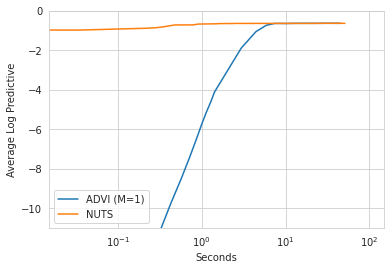

In [14]:
# Generate plot (Figure 4 in original paper)

output = output_advi.append(output_nuts, ignore_index=True)
output = output.loc[output['t'] < 100]
output['test_accuracy'] = output['test_accuracy'].astype('float')

sns.set_style("whitegrid")
results = sns.lineplot(data = output, x = 't', y = 'test_accuracy', hue = 'model')
results.set(xscale='log', 
            xlim = (0.015, 150),
            ylim = (-11, 0), 
            xlabel = 'Seconds',
            ylabel = 'Average Log Predictive')
plt.legend(labels=["ADVI (M=1)","NUTS"])